# Dataset Collection

To collect the dataset, we use a GUI framework on the Nvidia Jetson Orin Nano to read EOG signals via a serial connection. The function read_serial_continuous() reads data from the serial port, converting bytes to a string and removing extraneous spaces or newline characters. Before data collection begins, start_countdown() initiates a countdown, preparing users for the session by displaying a countdown and centering a pointer on the screen. This pointer then moves according to the move_sequence() function. We transform the EOG signals for improved visualization and analysis, normalizing and shifting their range. The pointer data is transformed from discrete points to a continuous pulse shape through wavelet denoising, using denoise_signal() to apply a Discrete Wavelet Transform () and reduce noise. To accurately label blink events without manual input, we developed an algorithm that automates this task, distinguishing blinks from movements. After verifying the EOG signal quality and trimming as needed, we save the refined data into an Excel file.

### 1. Adding required libraries

In [44]:
import time
import serial
import pandas as pd
import openpyxl
from openpyxl import Workbook 
import matplotlib.pyplot as plt
import math
import random
import tkinter as tk
import pywt
import numpy as np
import threading
from threading import Event
import os
from scipy.signal import find_peaks
import re
import datetime

### 2. Defining necessary functions

In [2]:
def read_serial_continuous():
    global eog_hor, eog_ver, eog_t, start_time
    pattern = re.compile(r'H:(\d+), V:(\d+)')  # Regular expression to match the expected format

    while not exit_flag.is_set():
        if ser.in_waiting > 0:
            try:
                line = ser.readline().decode('utf-8', errors='ignore').rstrip()
            except UnicodeDecodeError:
                continue  # Skip to the next iteration on decoding errors

            match = pattern.match(line)  # Try to match the line to the pattern
            if match:
                # Extract the horizontal and vertical values from the matched data
                hor_part, ver_part = match.groups()
                
                # Convert these string values into integers for processing
                hor_value_int = int(hor_part)
                ver_value_int = int(ver_part)

                # Ensure the values fall within the expected range (0-1023)
                if 0 <= hor_value_int <= 1023 and 0 <= ver_value_int <= 1023:
                    # Append the valid data to their respective lists for further analysis
                    eog_hor.append(hor_value_int)
                    eog_ver.append(ver_value_int)
                    # Record the time elapsed since the start of the data collection
                    eog_t.append(time.perf_counter() - start_time)

In [3]:
def start_countdown(number):
    global start_time  # Declare start_time as global to track the countdown's start
    if number > 0:
        # Clears the canvas for a fresh display of the countdown number
        canvas.delete("all")
        # Display the current countdown number at the screen's center
        canvas.create_text(center_x, center_y, text=str(number), font=('Helvetica', 48), fill='black')
        # Calls itself with the next lower number after 1000ms (1 second)
        window.after(1000, start_countdown, number - 1)
    else:
        # Marks the beginning of the data collection period
        start_time = time.perf_counter()
        # Starts a new thread that reads serial data continuously without blocking the GUI
        threading.Thread(target = read_serial_continuous, daemon=True).start()  # Start serial reading
        # Begin the sequence of moving points after the countdown
        move_sequence()

In [29]:
def move_sequence(step = 0):
    global last_point, pointer_x, pointer_y, pointer_t, start_time
    # Clears the canvas for the next visual
    canvas.delete("all")
        
    # Alternates between centering the pointer and moving it to a random location
    if step % 2 == 0:  # Even steps reset the pointer to the screen's center
        x_transformed, y_transformed = 0, 0
    else:  # Odd steps relocate the pointer to a random positio
        x = random.randint(0, window.winfo_screenwidth())
        y = random.randint(0, window.winfo_screenheight())
        # Adjust coordinates to use screen center as origin
        x_transformed = x - center_x
        y_transformed = center_y - y  # Subtract from center_y to invert the Y axis

    # Connects the current point to the previous one with a line
    if last_point is not None:
        canvas.create_line(last_point[0] + center_x, center_y - last_point[1], 
                           x_transformed + center_x, center_y - y_transformed, fill='black', width=2)
    
    # Visualizes the current point
    radius = 10
    canvas.create_oval(x_transformed + center_x - radius, center_y - y_transformed - radius, 
                       x_transformed + center_x + radius, center_y - y_transformed + radius, fill='blue', outline='blue')
    
     # Prepares for the next move
    last_point = (x_transformed, y_transformed)  # Updates last_point for continuity
    pointer_x.append(x_transformed)  # Store the transformed X position
    pointer_y.append(y_transformed)  # Store the transformed Y position
    pointer_t.append(time.perf_counter() - start_time)  # Update the timestamp list with the elapsed time
    
    # Check if we should continue the sequence
    if step < 10:  # Continue for 30 seconds total, considering 3s per position
        window.after(2000, move_sequence, step + 1)
    else:
        # Concludes the sequence and triggers application closure
        window.after(2000, exit_application)

In [5]:
def exit_application():
    """Function to close the application."""
    exit_flag.set() # Signals the background data-reading thread to terminate.
    window.destroy()  # Closes the Tkinter GUI window, effectively stopping the GUI loop.
    ser.close() # Safely closes the serial connection to free up system resources.

In [1]:
def normalize (var, limit):
    normalized_var = [int(val)/limit for val in var]  # Normalize a list of values by a given limit. 
    return normalized_var                             # Normalized values is then returned.

In [2]:
def shift_to_center (var, center):
    shifted_var = [(int(val) - center)  for val in var] # Shift a list of values so that they are centered around the 'center' value
    return shifted_var                                  # Shifted list of values is then returned.

In [3]:
def denoise_signal(signal, wavelet='sym20', level=1):
    """
    Denoise a signal using Discrete Wavelet Transform (DWT) and soft thresholding.
    
    Parameters:
    - signal: The input signal (1D numpy array).
    - wavelet: The type of wavelet to use (e.g., 'db4, haar, sym20').
    - level: The level of wavelet decomposition.
    
    Returns:
    - The denoised signal as a 1D numpy array.
    """
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    
    # Calculate the threshold using the universal threshold method
    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    
    # Apply soft thresholding to remove noise
    coeff_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeff]
    
    # Reconstruct the signal using the thresholded coefficients
    denoised_signal = pywt.waverec(coeff_thresh, wavelet, mode='symmetric')

    # Ensuring the denoised signal has the same length as the input signal.
    if len(denoised_signal) > len(signal):
        denoised_signal = denoised_signal[:len(signal)]
    
    return denoised_signal

In [4]:
def determine_mode(X, Y):
    # Initialize counters for each mode
    mixed_count = 0        # Counts instances indicating actions other than blinking
    blink_only_count = 0   # Counts instances suggesting a blink has occurred

    # Iterate over pairs of X and Y coordinates
    for x, y in zip(X, Y):
        if x == 0 and y == 0:
            # Both X and Y are at the center, indicating a potential blink
            blink_only_count += 1
        else:
            # Either X or Y (or both) are not at the center, indicating a mixed mode
            mixed_count += 1

    # Determine the predominant mode of action
    if mixed_count > 0:
        return "mixed"              # Mixed activities detected
    elif blink_only_count > 0:
        return "blink only"           # Only blinks detected
    else:
        return "undetermined"  # In case there are no movements or blinks detected

In [5]:
def find_edges(y_list):
    # Initialize empty lists to store the indices of rising and falling edges
    rising_edges = []        # To capture the points where the signal goes up
    falling_edges = []       # To capture the points where the signal goes down

    # Iterate through the list 
    for i in range(1, len(y_list)):
        if y_list[i] > y_list[i-1]:  # Rising edge
            rising_edges.append(i)
        elif y_list[i] < y_list[i-1]:  # Falling edge
            falling_edges.append(i)
    # Return the lists of indices where rising and falling edges occur.        
    return rising_edges, falling_edges

In [12]:
def find_closest_peaks_after_edges(VER, edges, Length_signal, is_rising=True):
    closest_peaks = []
    # Find the closest peak following it
    
    for edge_idx in edges:
           # Search for peaks in the specified direction from the edge
        if is_rising:
           # For rising edges, identify the maximum value (peak) in the signal within the search range
            max_value= np.max(VER[edge_idx: edge_idx + Length_signal])
            peaks = np.argmax(VER[edge_idx: edge_idx + Length_signal]) + edge_idx
            
        else:
           # For falling edges, find the minimum value (trough) in the signal by inverting VER within the search range
            min_value= np.min(VER[edge_idx: edge_idx + Length_signal])
            peaks = np.argmin(VER[edge_idx: edge_idx + Length_signal]) + edge_idx 

          # Add the index of the closest peak (or trough for falling edges) to the list
        closest_peaks.append(peaks)

    return closest_peaks

In [7]:
def zero_out_from_zero_to_zero(signal, peaks):
    modified_signal = np.copy(signal)  # Creates a copy to preserve the original signal
    for peak in peaks:
        # Find the preceding zero crossing by moving backwards from the peak.
        start = peak
        while start > 0 and signal[start] * signal[start-1] > 0:  # product > 0 means no zero crossing
            start -= 1

        # Find the following zero crossing by moving forwards from the peak.
        end = peak
        while end < len(signal) - 1 and signal[end] * signal[end+1] > 0:  # product > 0 means no zero crossing
            end += 1

        # Set the signal values to zero from the start to end indices, inclusive.
        modified_signal[start:end+1] = 0
    
    return modified_signal

In [8]:
def unite_close_pulses(binary_signal, vicinity):
    # Generates a kernel of ones with length equal to the specified vicinity
    kernel = np.ones(vicinity, dtype=int)
    
    # Convolve the binary signal with the kernel to identify regions of closeness
    convolved = np.convolve(binary_signal, kernel, mode='same')
    
    # Wherever the convolved signal is greater than 0, set to 1 (indicating close or actual pulse)
    united_signal = np.where(convolved > 0, 1, 0)
    
    return united_signal

In [9]:
def write_to_csv(name_of_csv, data):    
    # Load the existing Excel workbook
    book = openpyxl.load_workbook(name_of_csv)

    # Access the target sheet within the workbook
    sheet = book['Sheet1']

    # Determine the starting row for appending new data
    last_row = sheet.max_row

    # Iterate over the DataFrame, writing each value to the appropriate cell
    for index, row in data.iterrows():
        for col_num, value in enumerate(row.values, 1):
            sheet.cell(row=last_row + index + 1, column=col_num, value=value)

    # Save the workbook with the appended data
    book.save(name_of_csv)

In [10]:
def save_excel_with_version(df, base_name="EOG_Dataset", version="0.7.18", date_input=None):
    """
    Saves a DataFrame to an Excel file, naming it with a base name, version number,
    current time, and date. If no date is specified, the current date is used.
    """
    # Capture the current moment for timestamping
    now = datetime.datetime.now()
    time_str = now.strftime("%H.%M")  # Format time as "HH.MM"
    
    # Determine the date string, using either the provided date or the current date
    if date_input is None:
        date_str = now.strftime("%m.%d.%Y")  # Format date as "MM.DD.YYYY"
    else:
        date_str = date_input
    
    # Construct the file name with versioning and timestamp
    file_name = f"{base_name}_V{version}({time_str}_{date_str}).xlsx"
    
    # Export the DataFrame to an Excel file 
    df.to_excel(file_name, index=False)
    print(f"File saved as: {file_name}")
    return file_name

### 3. GUI

In [34]:
# Establish a serial connection to receive EOG data.
ser = serial.Serial('/dev/ttyACM0',9600)
# Setup a threading event to gracefully exit the read loop.
exit_flag = Event()   

# Initialize lists to store X, Y positions, and timestamps for the moving pointer.
pointer_x = []  # Will store the X positions of the points
pointer_y = []  # Will store the Y positions of the points
pointer_t = []  # Will store timestamps for pointer

# Initialize lists to store horizontal and vertical EOG values and their timestamps.
eog_hor = []    # Will store eog horizontal values
eog_ver = []    # Will store eog vertical values
eog_t = []      # Will store timestamps for eog readings
                       
# Initialize the main Tkinter window for the GUI.
window = tk.Tk()
window.title("Random Points with Single Line") # Set the window title.
window.attributes('-fullscreen', True)  # Launch the window in full-screen mode.

# Calculate the center of the screen to use as a reference point.
center_x = window.winfo_screenwidth() // 2
center_y = window.winfo_screenheight() // 2

# Prepare for drawing by setting the initial point to None.
last_point = None  # Initialize last_point as None

# Create a canvas that fills the entire screen, setting the background to grey.
canvas = tk.Canvas(window, bg='white')
canvas.pack(fill=tk.BOTH, expand=True)

# Bind the Escape key to the exit_application function for easy exit.
window.bind("<Escape>", exit_application)

# Initiate a countdown before starting data collection, to allow the user to prepare.
start_countdown(5)

# Enter the Tkinter main loop to start the GUI.
window.mainloop()

In [35]:
ser.close()

### 4. Normalizing Signals (-1, 1)

In [37]:
# shifting eog (horizontal and vertical) values from (0,1023) to (-512, 511)
eog_hor_shifted = shift_to_center (eog_hor, 512)
eog_ver_shifted = shift_to_center (eog_ver, 512)
# normalizing eog (horizontal and vertical) values from (-512, 511) to (-1, 1)
eog_hor_normalized = normalize (eog_hor_shifted, 512)
eog_ver_normalized = normalize (eog_ver_shifted, 512)
# normalizing pointer horizontal pixel values from (-x, x) to (-1,1)
pointer_x_normalized = normalize (pointer_x, center_x)
# normalizing pointer vertical pixel values from (-y, y) to (-1,1)
pointer_y_normalized = normalize (pointer_y, center_y)

### 5. Converting pointer data to pulse

In [38]:
# Convert lists of timestamps and normalized positions into numpy arrays for efficient data handling.
eog_t_np = np.array(eog_t)  # Convert EOG timestamps to a numpy array.
pointer_t_np = np.array(pointer_t) # Convert pointer timestamps to a numpy array.
pointer_x_np = np.array(pointer_x_normalized)  # Convert normalized X positions to a numpy array.
pointer_y_np = np.array(pointer_y_normalized)  # Convert normalized X positions to a numpy array.

# Prepare arrays to store the continuous representation of pointer positions over time.
pointer_x_pulse = np.zeros_like(eog_t_np) # Initialize with zeros to match the timestamps' length.
pointer_y_pulse = np.zeros_like(eog_t_np) # Initialize with zeros to match the timestamps' length.

# Iterate over each t_pointer to find matching indices in eog_t
for i in range(len(pointer_t_np)):
    # Calculate the closest matching index in EOG timestamps for the current pointer timestamp.
    start_index = np.abs(eog_t_np - pointer_t_np[i]).argmin()
    # For the end index, find the closest match for the next timestamp or use the last index if it's the final timestamp.
    end_index = np.abs(eog_t_np - pointer_t_np[i + 1]).argmin() if i + 1 < len(pointer_t_np) else len(eog_t_np)
    
    # Update the pulse arrays with the pointer position, creating a continuous line from start to end index.
    pointer_x_pulse[start_index:end_index] = pointer_x_np[i] # Assign X values.
    pointer_y_pulse[start_index:end_index] = pointer_y_np[i] # Assign Y values.

### 6. Denoising the raw EOG signal

In [39]:
# Denoise vertical EOG signals using two different wavelets (haar denoised signal is used for labelling blink events)
eog_ver_denoised_sym = denoise_signal(eog_ver_normalized, wavelet='sym20')
eog_ver_denoised_haar = denoise_signal(eog_ver_normalized, wavelet='haar')

# Denoise horizontal EOG signals using the 'sym20' wavelet
eog_hor_denoised_sym = denoise_signal(eog_hor_normalized, wavelet='sym20')

### 7. Visualization

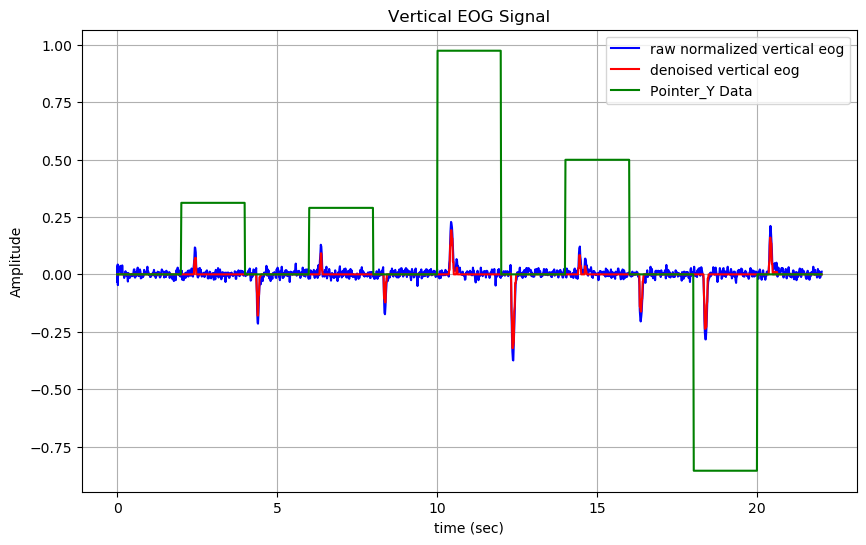

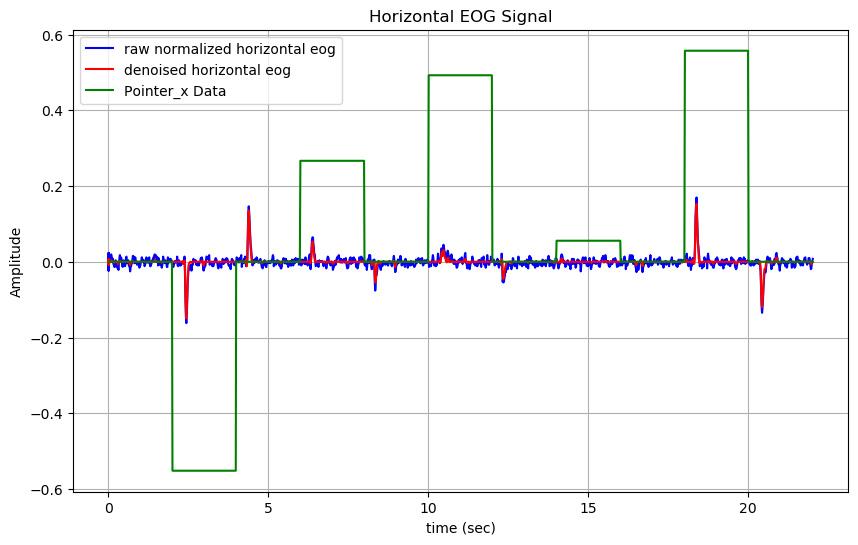

In [43]:
plt.figure(figsize=(10, 6))  # Specifies the figure size
plt.plot(eog_t, eog_ver_normalized, label='raw normalized vertical eog', color='blue') 
plt.plot(eog_t, eog_ver_denoised_haar, label='denoised vertical eog', color='red')
plt.plot(eog_t, pointer_y_pulse, label='Pointer_Y Data', color='green') 
plt.title('Vertical EOG Signal')  # Set the title of the plot
plt.xlabel('time (sec)')  # Set the x-axis label
plt.ylabel('Amplitude')  # Set the y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show grid lines for better readability
plt.show()  # Display the plot

plt.figure(figsize=(10, 6))  # Specifies the figure size
plt.plot(eog_t, eog_hor_normalized, label='raw normalized horizontal eog', color='blue')  
plt.plot(eog_t, eog_hor_denoised_sym, label='denoised horizontal eog', color='red')
plt.plot(eog_t, pointer_x_pulse, label='Pointer_x Data', color='green') 
plt.title('Horizontal EOG Signal')  # Set the title of the plot
plt.xlabel('time (sec)')  # Set the x-axis label
plt.ylabel('Amplitude')  # Set the y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show grid lines for better readability
plt.show()  # Display the plot

### 8. Blink Detection

The mode is: mixed


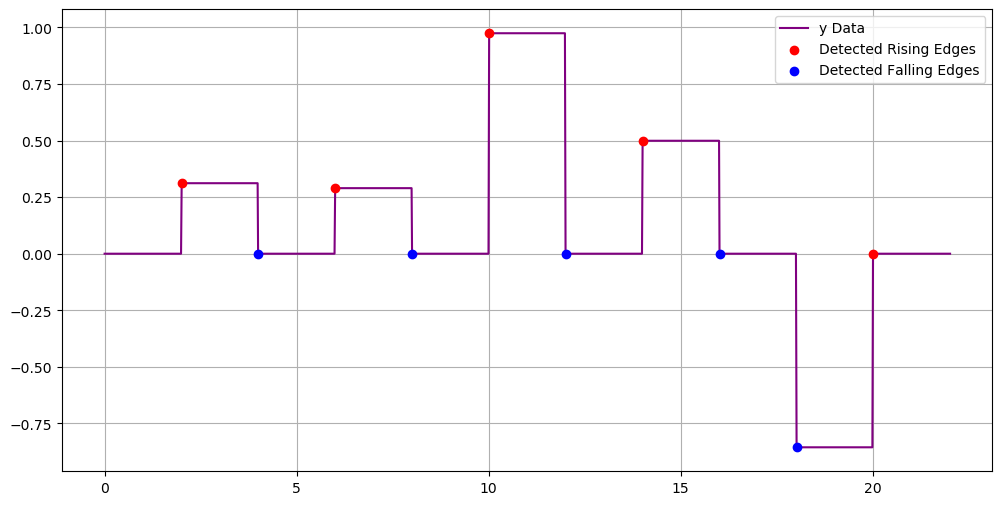

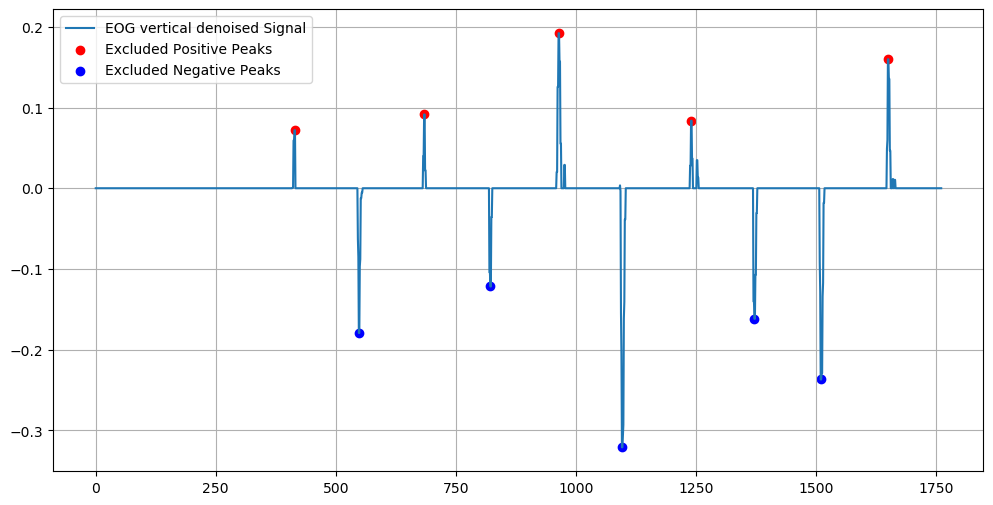

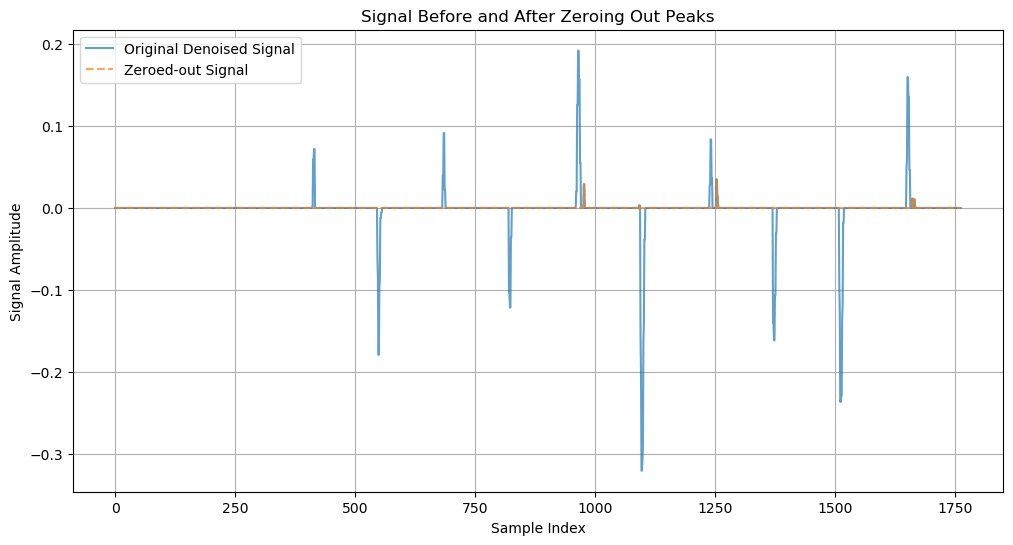

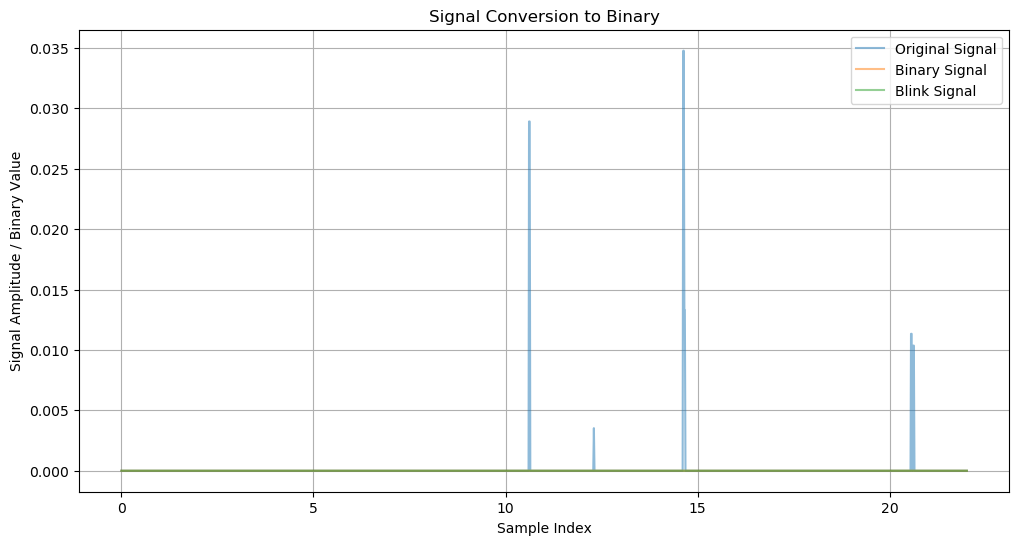

In [41]:
# Determine if pointer movements are predominantly mixed or blink-only based on normalized coordinates
mode = determine_mode(pointer_x_normalized, pointer_y_normalized)
print(f"The mode is: {mode}")

# Detect rising and falling edges in the y component of the pulse signal.
if mode == 'mixed':
    rising_edges, falling_edges = find_edges(pointer_y_pulse)
    rising_edges = np.array(rising_edges)
    falling_edges = np.array(falling_edges)
    # Visualize the signal with detected edges highlighted for analysis.
    plt.figure(figsize=(12, 6))
    plt.plot(eog_t_np, pointer_y_pulse, label='y Data', color='purple') 
    plt.scatter(eog_t_np[rising_edges], pointer_y_pulse[rising_edges], color='red', zorder=3, label='Detected Rising Edges')
    plt.scatter(eog_t_np[falling_edges], pointer_y_pulse[falling_edges], color='blue', zorder=3, label='Detected Falling Edges')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Determine the length of the signal for peak detection.
    Length_signal =(abs(rising_edges[0] - falling_edges[0])-1)//4

    # Identify closest peaks following rising and falling edges 
    excluded_pos_peaks = find_closest_peaks_after_edges(eog_ver_denoised_haar, rising_edges, Length_signal, is_rising=True)
    excluded_neg_peaks = find_closest_peaks_after_edges(eog_ver_denoised_haar, falling_edges, Length_signal, is_rising=False)

    # Combine excluded peaks
    excluded_peaks = np.sort(np.concatenate((excluded_pos_peaks, excluded_neg_peaks)))

    # Visualize the denoised signal with excluded peaks highlighted.
    plt.figure(figsize=(12, 6))
    plt.plot(eog_ver_denoised_haar, label='EOG vertical denoised Signal')
    plt.scatter(excluded_pos_peaks, eog_ver_denoised_haar[excluded_pos_peaks], color='red', label='Excluded Positive Peaks')
    plt.scatter(excluded_neg_peaks, eog_ver_denoised_haar[excluded_neg_peaks], color='blue', label='Excluded Negative Peaks')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Zero out the signal segments between zero-crossings around the excluded peaks.   
    eog_ver_zeroed = zero_out_from_zero_to_zero(eog_ver_denoised_haar, excluded_peaks)
    
    # Compare the original denoised signal with the zeroed-out version.      
    plt.figure(figsize=(12, 6))
    plt.plot(eog_ver_denoised_haar, label='Original Denoised Signal', alpha=0.7)
    plt.plot(eog_ver_zeroed, label='Zeroed-out Signal', linestyle='--', alpha=0.7)
    plt.legend()
    plt.title('Signal Before and After Zeroing Out Peaks')
    plt.xlabel('Sample Index')
    plt.ylabel('Signal Amplitude')
    plt.grid(True)
    plt.show()
    
elif mode == 'blink only':
    # If the mode is exclusively blinking, retain the denoised signal without further processing
    eog_ver_zeroed = eog_ver_denoised_haar

    # Convert the (zeroed or original) signal to binary based on a threshold amplitude
    binary_signal = np.where(abs(eog_ver_zeroed) <= 0.06, 0, 1)   
    vicinity = 3  

    # Unite close binary pulses to better represent blinks in the signal.
    Blink = unite_close_pulses(binary_signal, vicinity)
    
    # Visualize the final signal processing stages: original, binary, and blink signals    
    plt.figure(figsize=(12, 6))
    t1 = 1
    t2 = -1
    plt.plot(eog_t[t1:t2], eog_ver_zeroed[t1:t2], label='Original Signal', alpha=0.5)
    plt.plot(eog_t[t1:t2], binary_signal[t1:t2], label='Binary Signal', alpha=0.5)
    plt.plot(eog_t[t1:t2], Blink[t1:t2], label='Blink Signal', alpha=0.5)
    plt.legend()
    plt.title('Signal Conversion to Binary')
    plt.xlabel('Sample Index')
    plt.ylabel('Signal Amplitude / Binary Value')
    plt.grid(True)
    plt.show()

### 9. Saving Signal to CSV

In [ ]:
# Initialize a DataFrame for EOG data with specified column names.
EOG_columns = ['t_EOG', 'Hor', 'Ver', 'X', 'Y', 'Blink', 'Hor_denoised', 'Ver_denoised']
EOG_col = pd.DataFrame(columns=EOG_columns)

# Specify the date and version for the Excel file to be saved.
date_input = "03.26.2024"
current_version = "0.7.80"  

# Save the DataFrame with the version and date in the filename.
file_name = save_excel_with_version(EOG_col, version=current_version, date_input=date_input)

In [548]:
# Set indices to slice the signal data for a specific segment
t1 = 20
t2 = -20

# Create a DataFrame from slices of EOG signal data arrays, each representing a different aspect of the EOG measurement
EOG_data = pd.DataFrame({'t_EOG': eog_t[t1:t2],                            # Time stamps for the EOG data segment
                         'Hor': eog_hor_normalized[t1:t2],                 # Normalized horizontal EOG signals
                         'Ver': eog_ver_normalized[t1:t2],                 # Normalized vertical EOG signals
                         'X': pointer_x_pulse[t1:t2],                      # X-coordinate data from the pointer movement
                         'Y': pointer_y_pulse[t1:t2],                      # Y-coordinate data from the pointer movement
                         'Blink': Blink[t1:t2],                            # Binary blink detection data
                         'Hor_denoised': eog_hor_denoised_sym[t1:t2],      # Denoised horizontal EOG signals
                         'Ver_denoised': eog_ver_denoised_sym[t1:t2]})     # Denoised vertical EOG signals

# Call a function to append this DataFrame to an existing CSV file, preserving its data structure
write_to_csv(file_name, EOG_data)